In [571]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from python.mappings import FOOTBALL_LEAGUES_MAPPING, TEAMS_RANKING_MAPPING

from scipy.stats import f_oneway, shapiro, levene, kruskal

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn.metrics import root_mean_squared_error, root_mean_squared_log_error

%matplotlib inline

In [434]:
# Constant variables
TABLE_SIZE = 1546
TRAIN_RATIO = 0.8

In [435]:
# Joins train and test datasets together to simplify the process
def concat_df(df1, df2):
    return pd.concat([df1, df2], ignore_index=True)

# Divides the overall dataset into train and test 
def divide_df(df):
    train_size = int(TABLE_SIZE*TRAIN_RATIO)
    
    return df.loc[:train_size - 1], df.loc[train_size:] 

In [436]:
train_data = pd.read_csv('data/train_stats.csv')
test_data = pd.read_csv('data/test_stats.csv')
all_data = concat_df(train_data, test_data)

**1. PREPARATION STEP: Cleaning the data**

In [437]:
all_data.drop(['Player_URL', 'Team_URL'], axis=1, inplace=True)

In [438]:
# Cleans the columns containing commas 
def clean_comma(column):
    column = column.strip()
    column = column[:column.find(',')] + '' + column[column.find(',') + 1:]
    return column

# Cleans the columns containing '\t' symbol
def clean_tab(column):
    return column.strip().replace('\t', '')

In [439]:
comma_columns = ['Team', 'Position']
tab_columns = ['Goals', 'Assists', 'Yel', 'Red', 'SpG', 'AerialsWon', 'MotM', 'Tackles',
               'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb_x', 'Blocks', 'OwnG', 'KeyP',
               'Drb_y', 'Fouled', 'Off', 'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']

for column in comma_columns:
    all_data[column] = all_data[column].apply(clean_comma)
    
for column in tab_columns:
    all_data[column] = all_data[column].apply(clean_tab)

In [440]:
# Some columns with integer values contain symbol '-' instead of 0. The function fixes it
def remove_dashes(column):
    if column == '-':
        return 0
    return column

In [441]:
dash_columns = ['Goals', 'Assists', 'Yel', 'Red', 'SpG', 'AerialsWon', 'MotM', 'Tackles',
                'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb_x', 'Drb_y', 'Blocks', 'OwnG', 'KeyP',
                'Fouled', 'Off', 'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']

for column in dash_columns:
    all_data[column] = all_data[column].apply(remove_dashes)

In [442]:
# Now we have 'Value' variable containing market values in thousands or millions, but we want to get just an integer
def value_scaling(value):
    value = value.strip()
    
    if value.endswith('k'):
        return int(float(value[value.find('€')+1:value.find('k')]) * 10**3)
    elif value.endswith('m'):
        return int(float(value[value.find('€')+1:value.find('m')]) * 10**6)

In [443]:
all_data['Value'] = all_data['Value'].apply(value_scaling)

In [444]:
# We can divide 'Apps' variable because the number of appearances in starting squad is demonstrated in parentheses 
def appearances_division(apps):
    return apps[:apps.find('(')], apps[apps.find('(')+1:apps.find(')')]

In [445]:
all_data['Overall_Apps'], all_data['Start_Apps'] = zip(*all_data['Apps'].apply(appearances_division))

In [446]:
all_data.drop(['Apps'], axis=1, inplace=True)

In [447]:
# It would be better if we replace 'Forward', 'Midfielder' with their short forms (FW, M)

#all_data['Position'].value_counts()

def position_mapping(position):
    position = position.strip()
    
    if position == 'Forward': 
        return 'FW'
    elif position == 'Midfielder': 
        return 'M(C)'
    return position

all_data['Position'] = all_data['Position'].apply(position_mapping)

In [448]:
# We can divide 'Position' column into two positions (if some player has only one position, he`ll get NaN value for the second one).
def position_division(position):
    
    # only two main positions, that`s enough
    if position.count(',') >= 2:
        while position.count(',') != 1:
            position = position[:position.rfind(',')]
          
    if position.find(',') != -1:
        return pd.Series([position[:position.find(',')].strip(), position[position.find(',')+1:]]).values
    return pd.Series([position.strip(), np.nan]).values

# Center (C), Right (R) or Left (L)? This information is contained in parentheses
def position_side(position):
    
    # np.nan has 'float' type
    if type(position) != float:
        if position.find('(') != -1:
            sides = tuple(position[position.find('(')+1:position.find(')')])
            position = position[:position.find('(')].strip(),
            
            return position + sides + tuple([np.nan] * (3 - len(sides)))
        else:
            position = position.strip(),

            return position + tuple([np.nan] * 3)
    else:
        return tuple([np.nan] * 4)

In [449]:
all_data['Position_1'], all_data['Position_2'] = zip(*all_data['Position'].apply(position_division))

In [450]:
all_data['Position_1'], all_data['Side_11'], all_data['Side_12'], all_data['Side_13'] = zip(*all_data['Position_1'].apply(position_side))
all_data['Position_2'], all_data['Side_21'], all_data['Side_22'], all_data['Side_23'] = zip(*all_data['Position_2'].apply(position_side))

In [451]:
all_data.drop(['Position'], axis=1, inplace=True)

In [452]:
# Time to change column types
float_type = ['SpG', 'AerialsWon', 'Tackles', 'Inter', 'Fouls', 'Offsides',
              'Clear', 'Drb_x', 'Blocks', 'KeyP', 'Drb_y', 'Fouled', 'Off',
              'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']
int_type = ['Goals', 'Assists', 'Yel', 'Red', 'MotM', 'OwnG', 'Overall_Apps', 'Start_Apps']

all_data[float_type] = all_data[float_type].astype('float')
all_data[int_type] = all_data[int_type].astype('int64')

In [453]:
# Insert 'Value' variable at the end of the dataset
value_column = all_data.pop('Value')
all_data['Value'] = value_column

# Insert 'Position_2' variable before the variable 'Side_21'
pos2_column = all_data.pop('Position_2')
index = all_data.columns.get_loc('Side_21')
all_data.insert(index, 'Position_2', pos2_column)

**2. EXPLORATORY DATA ANALYSIS AND FEATURE ENGINEERING**

**GLOSSARY. DESCRIPTION OF THE VARIABLES**

- SpG - Shots per game
- PS(%) - Percentage of successful passes
- AerialsWon, Aerial - Header in a direct contest with an opponent
- MotM - Man of the Match
- Tackle - Dispossessing an opponent, whether the tackling player comes away with the ball or not
- Interception (Inter) - Preventing an opponent's pass from reaching their teammates
- Fouls - How often a player commits a foul
  Fouled - How often a player gets fouled
- Offsides - It`s referred to "offside won" - the last man to step up to catch an opponent in an offside position
  Off - How often a player gets in offside position
- Clearance (Clear) - Action by a defending player that temporarily removes the attacking threat on their goal/that effectively alleviate pressure on their goal
- Drb_x - How often a player gets dribbled (being dribbled past by an opponent without winning a tackle)
  Drb_y - Frequency of successful dribbles
- Blocks - The number of blocked shots per game
- OwnG - Own goal
- KeyP - Key passes (the final pass leading to a shot at goal from a teammate)
- Dispossessed (Disp) - How often a player gets tackled by an opponent without attempting to dribble past them
- UnsTch - ???
- Average Passes (AvgP) - Average number of passes attempted (short passes, long balls, through balls, crosses)
- Cross - An attempted/accurate pass from a wide position to a central attacking area
- Long Ball (LongB) - An attempted/accurate pass of 25 yards or more
- Through Ball (ThrB) - An attempted/accurate pass between opposition players in their defensive line to find an onrushing teammate (running through on goal)
- Apps - appearances on the football field

In [454]:
#all_data.info()

Let`s start with categorical variables.

We see that there are a lot of missing values for 'Side_2X' and 'Side_13' variables (>80%). It describes where a player is located on a football pinch (left, right or center). But it can be useful to create a variable that shows how much place some player "occupies", on how many sides he is able to play. If it isn`t shown (all three variables are NaN values), then we will set 1.

In [455]:
def position_sides(s1, s2, s3):
    sides_list = [s1, s2, s3]
    
    while np.nan in sides_list:
        sides_list.remove(np.nan)
    
    if len(sides_list) == 0:
        return 1
    return len(sides_list)

In [456]:
all_data['Position_1_Sides'] = all_data.apply(lambda x: position_sides(x['Side_11'], x['Side_12'], x['Side_13']), axis=1)
all_data['Position_2_Sides'] = all_data.apply(lambda x: position_sides(x['Side_21'], x['Side_22'], x['Side_23']), axis=1)

Other variables have no missing values so we can continue in our research

'Team' variable can be very useful: we can extract a league in which a football player competes, and it is somehow influences his market value. For instance, we expect that in Premier League players cost more because of higher level of this championship and some other aspects. For this task we will use our mapping.

Also, we can divide our teams into three groups (A, B, C) based on their level ranking. Perhaps, players from "big teams" are more expensive 

In [457]:
all_data['League'] = all_data['Team'].map(FOOTBALL_LEAGUES_MAPPING)
all_data['Team_rank'] = all_data['Team'].map(TEAMS_RANKING_MAPPING)

Let`s check our presumptions by creating some plots!

In [458]:
order_rank = ['A-tier', 'B-tier', 'C-tier']

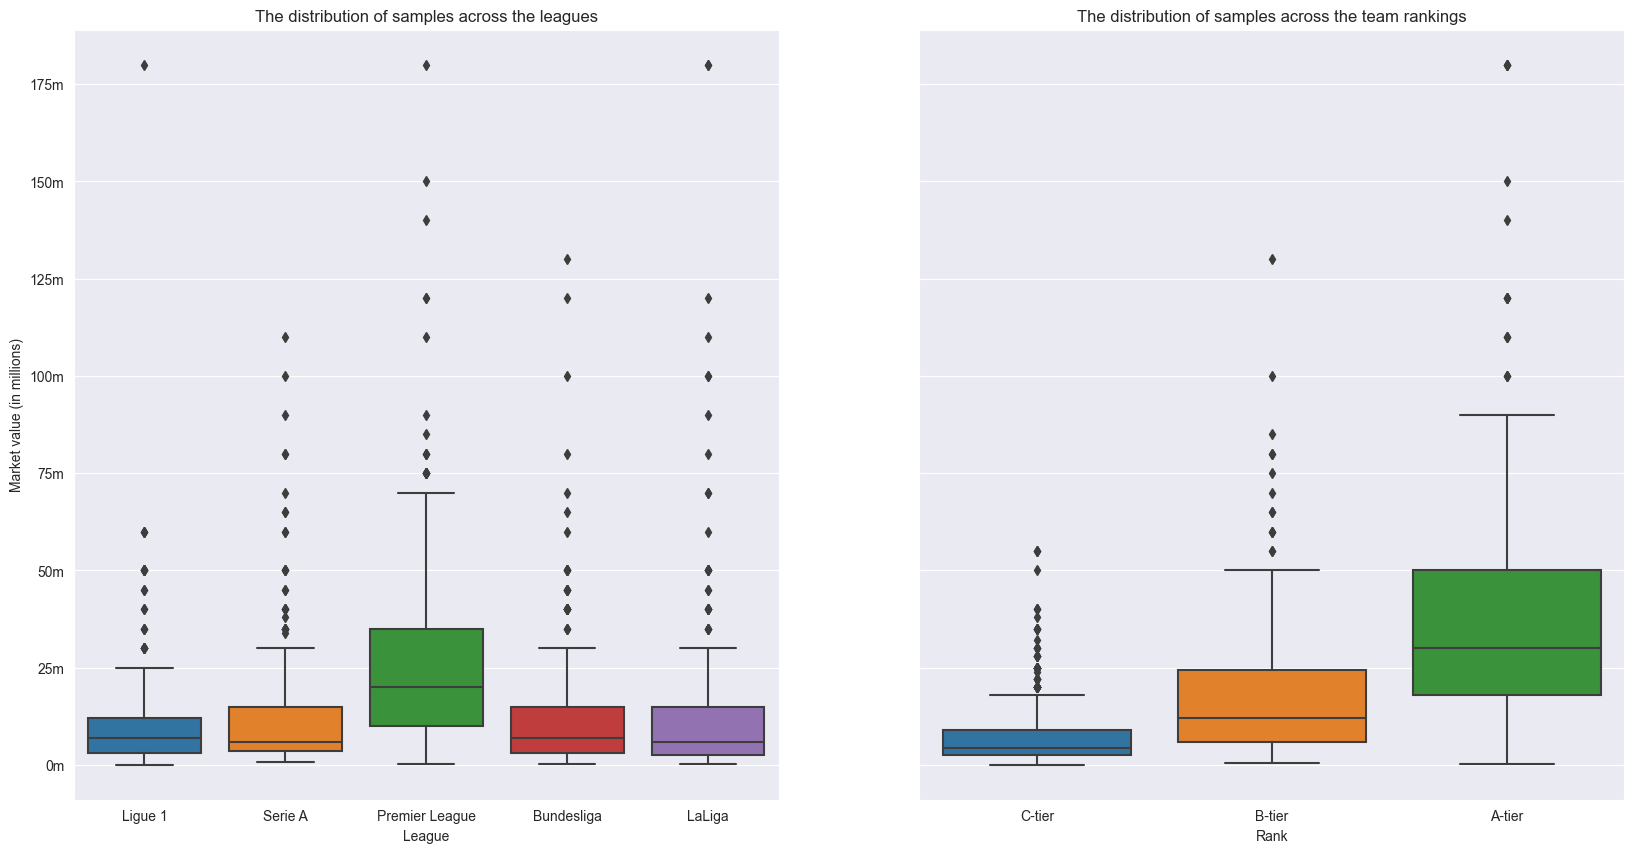

In [459]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

sns.boxplot(all_data,
            x='League',
            y='Value',
            ax=ax[0])

sns.boxplot(all_data,
            x='Team_rank',
            y='Value',
            order=reversed(order_rank),
            ax=ax[1])

ax[0].set_title('The distribution of samples across the leagues')
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_title('The distribution of samples across the team rankings')
ax[1].set_xlabel('Rank')
ax[1].set_ylabel('')

plt.show()

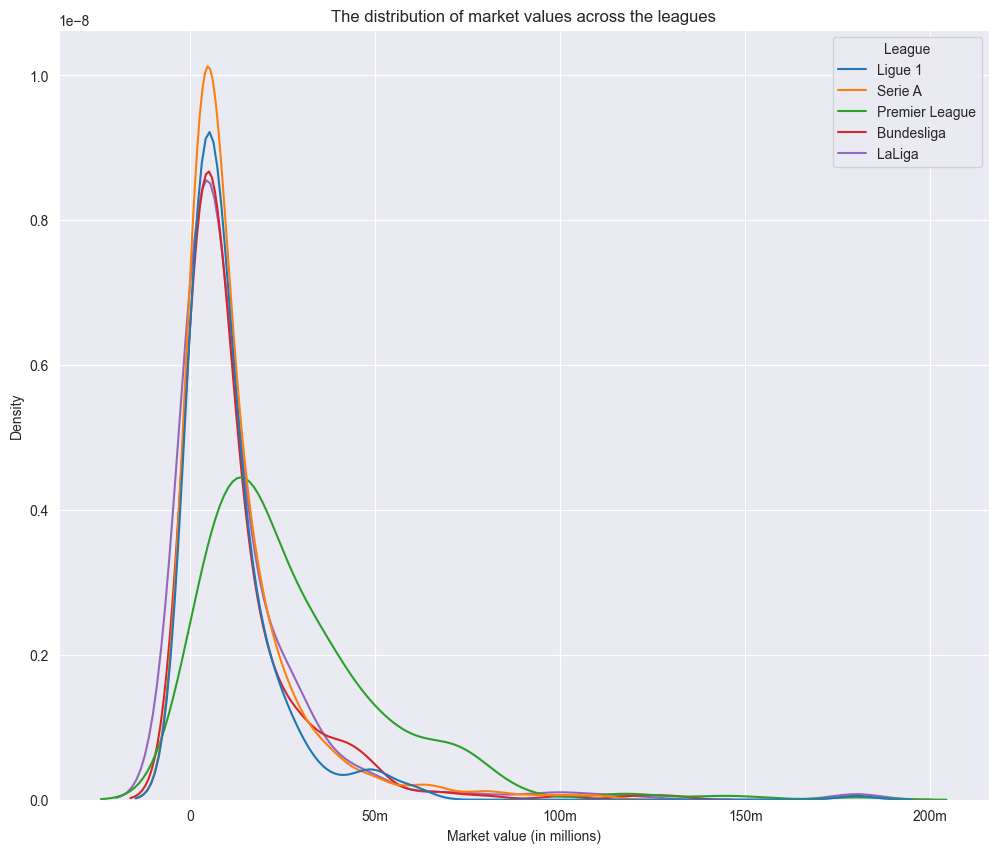

In [460]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='League')

ax.set_title('The distribution of market values across the leagues')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

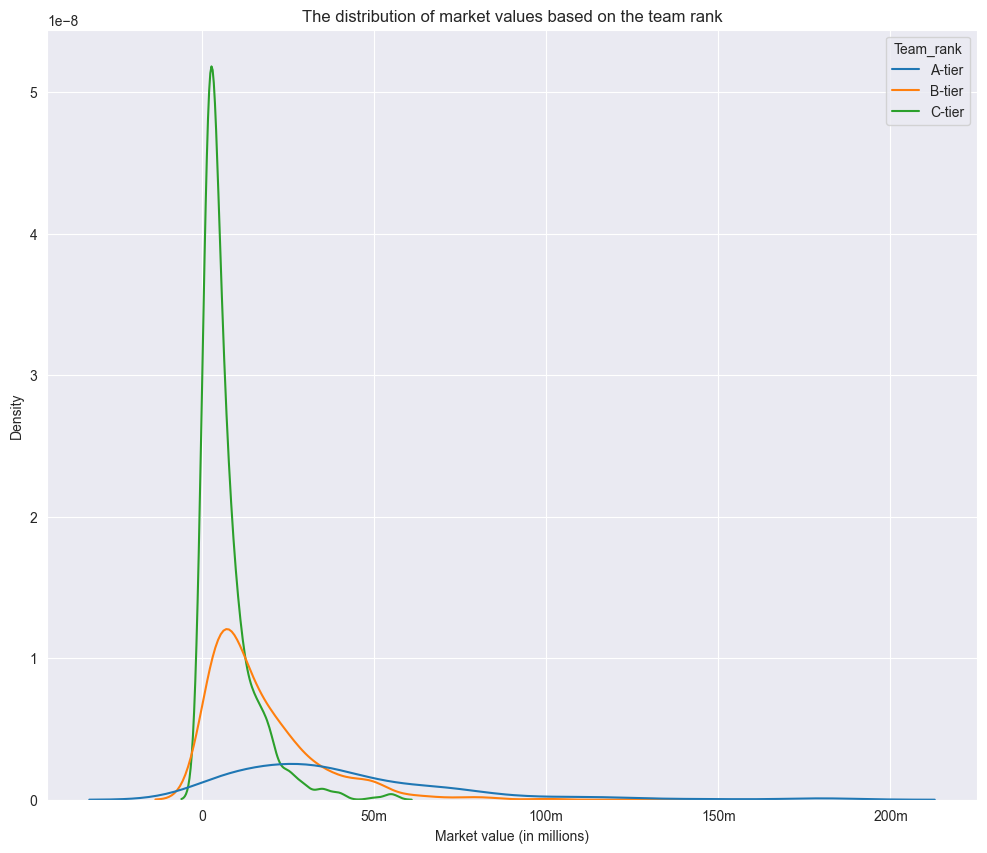

In [461]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='Team_rank',
            hue_order=order_rank)

ax.set_title('The distribution of market values based on the team rank')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

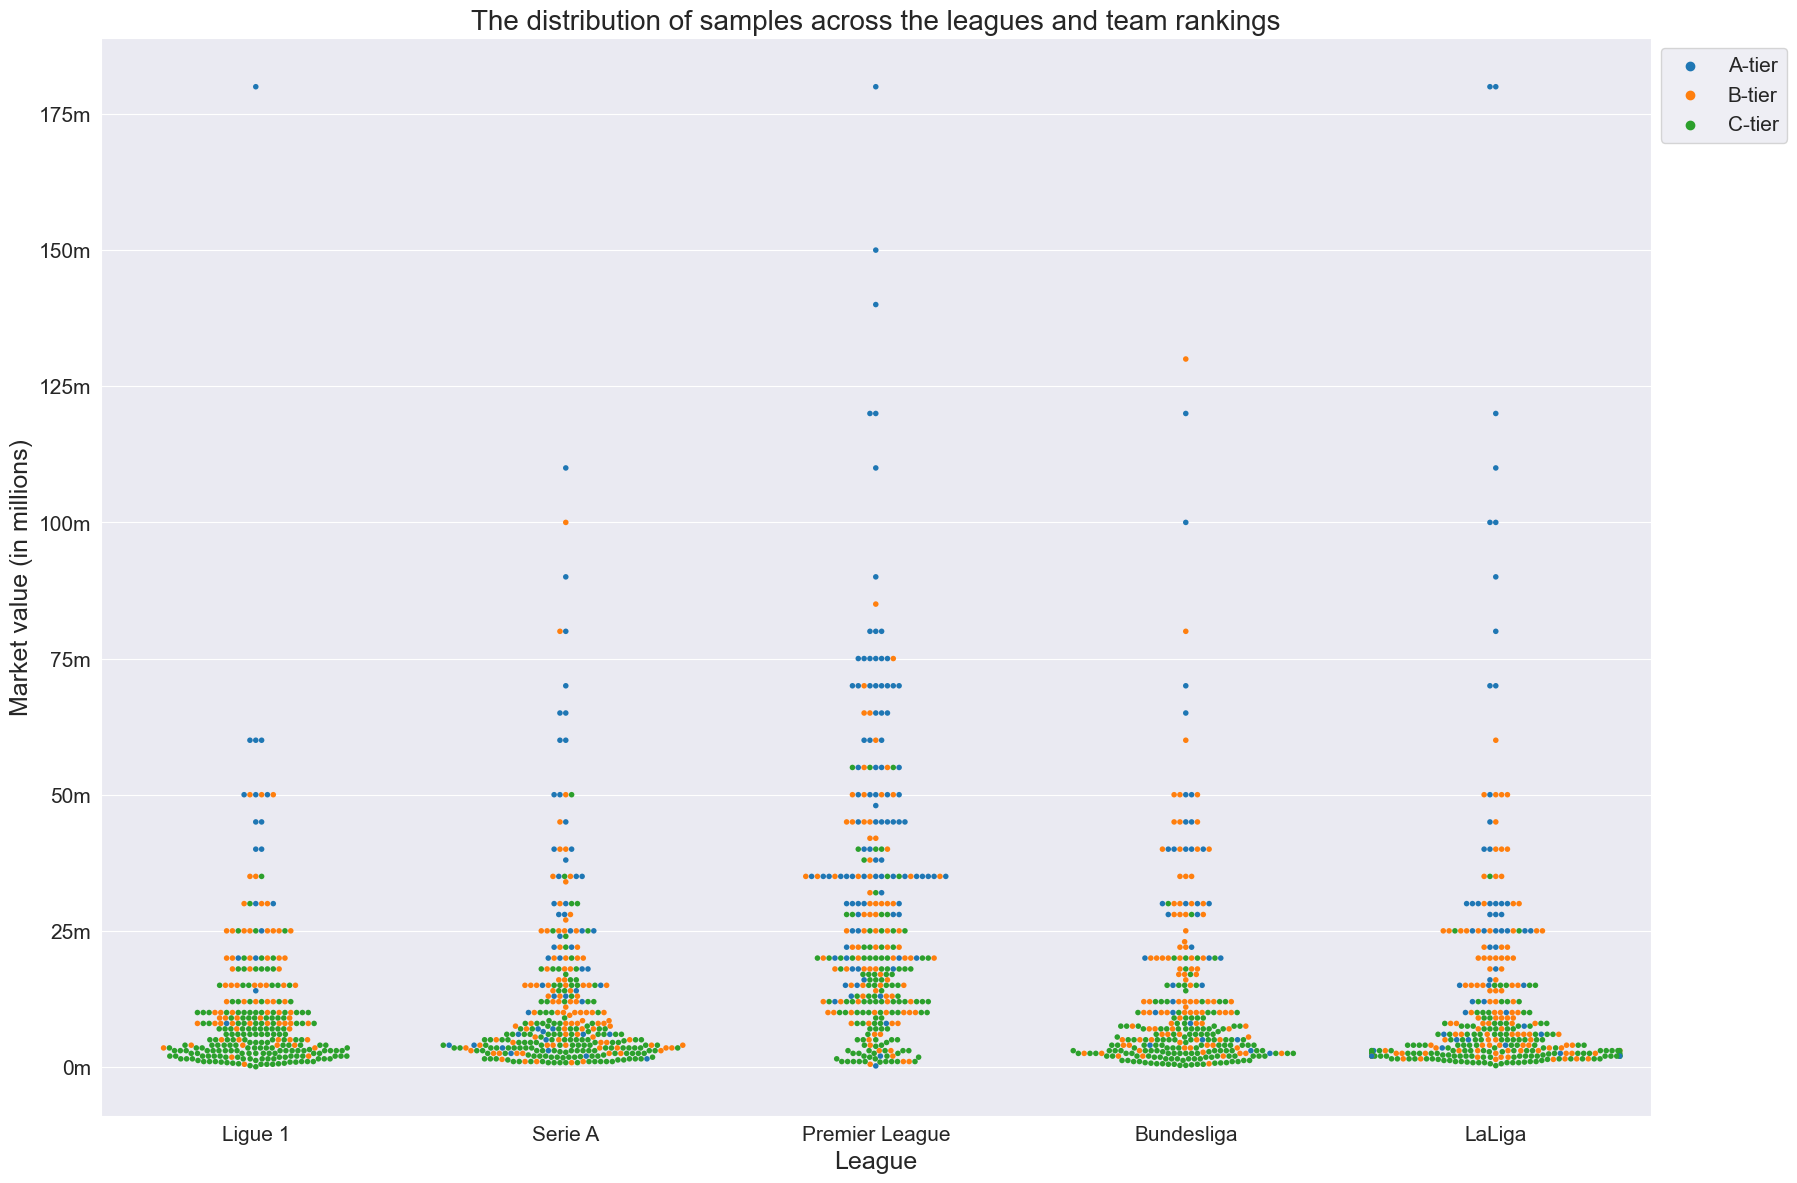

In [462]:
fig, ax = plt.subplots(figsize=(20, 14))

sns.swarmplot(all_data,
              x='League',
              y='Value',
              size=4,
              hue='Team_rank',
              hue_order=order_rank,
              ax=ax)

ax.set_title('The distribution of samples across the leagues and team rankings', fontsize=20)
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)', fontsize=18)
ax.xaxis.label.set_size(18)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(bbox_to_anchor=(1, 1), loc=2, fontsize=15)

plt.show()

On the first graph we can see that the distributions are almost the same across the leagues, but the Premier league has a little bit different one with higher market values than for other leagues.

From the second one we can notice that the distributions for A-ranked and B-ranked clubs are more heavy-tailed than for C-ranked teams, and in general, the majority of players in "small clubs" are located on the left part of the graph.

In [463]:
# Creates a table with different descriptive statistics for different groups of a categorical variable 
def descriptive_table(table, variable):
    indices=table.groupby(variable)['Value'].mean().index
    counts = table.groupby(variable)['Value'].count().values
    means = table.groupby(variable)['Value'].mean().values
    stds = table.groupby(variable)['Value'].std().values
    medians = table.groupby(variable)['Value'].median().values
    quantile_ninty = table.groupby(variable)['Value'].quantile(q=0.9).values
    
    table =  pd.DataFrame({'Sample size': counts,
                           'Mean': means,
                           'St. deviation': stds,
                           'Median': medians,
                           '90% quantile': quantile_ninty
                           }, index=indices)
    return table    

In [464]:
for item in ['League', 'Team_rank']:
    print(f"Variable: {item}")
    display(descriptive_table(all_data, item))

Variable: League


,Sample size,Mean,St. deviation,Median,90% quantile
League,,,,,
Bundesliga,296,1.282111e+07,1.714876e+07,7000000.0,30000000.0
LaLiga,329,1.309073e+07,2.152709e+07,6000000.0,30000000.0
Ligue 1,284,1.107042e+07,1.529310e+07,7000000.0,25000000.0
Premier League,314,2.796656e+07,2.559655e+07,20000000.0,63500000.0
Serie A,323,1.243467e+07,1.585947e+07,6000000.0,29600000.0


Variable: Team_rank


,Sample size,Mean,St. deviation,Median,90% quantile
Team_rank,,,,,
A-tier,252,3.962778e+07,3.309946e+07,30000000.0,75000000.0
B-tier,490,1.708265e+07,1.607032e+07,12000000.0,40000000.0
C-tier,804,7.073507e+06,7.581229e+06,4250000.0,17000000.0


**Idea**: We can create a variable that indicates whether some footballer plays in Premier League instead of 'League' column

In [465]:
all_data['From EPL'] = all_data['League'] == 'Premier League'

Now we will work with positions. It can be very useful to divide player`s positions into four groups (attack, midfield, defence and goalkeeper) because we can expect that the players in attack line cost more than goalkeepers. We will only operate with the main position and create 'Position' column.

In [466]:
position_mapping = {'FW': 'Attack',
                    'AM': 'Midfield',
                    'M': 'Midfield',
                    'DMC': 'Midfield',
                    'D': 'Defence',
                    'GK': 'Goalkeeper'}

all_data['Position'] = all_data['Position_1'].map(position_mapping)

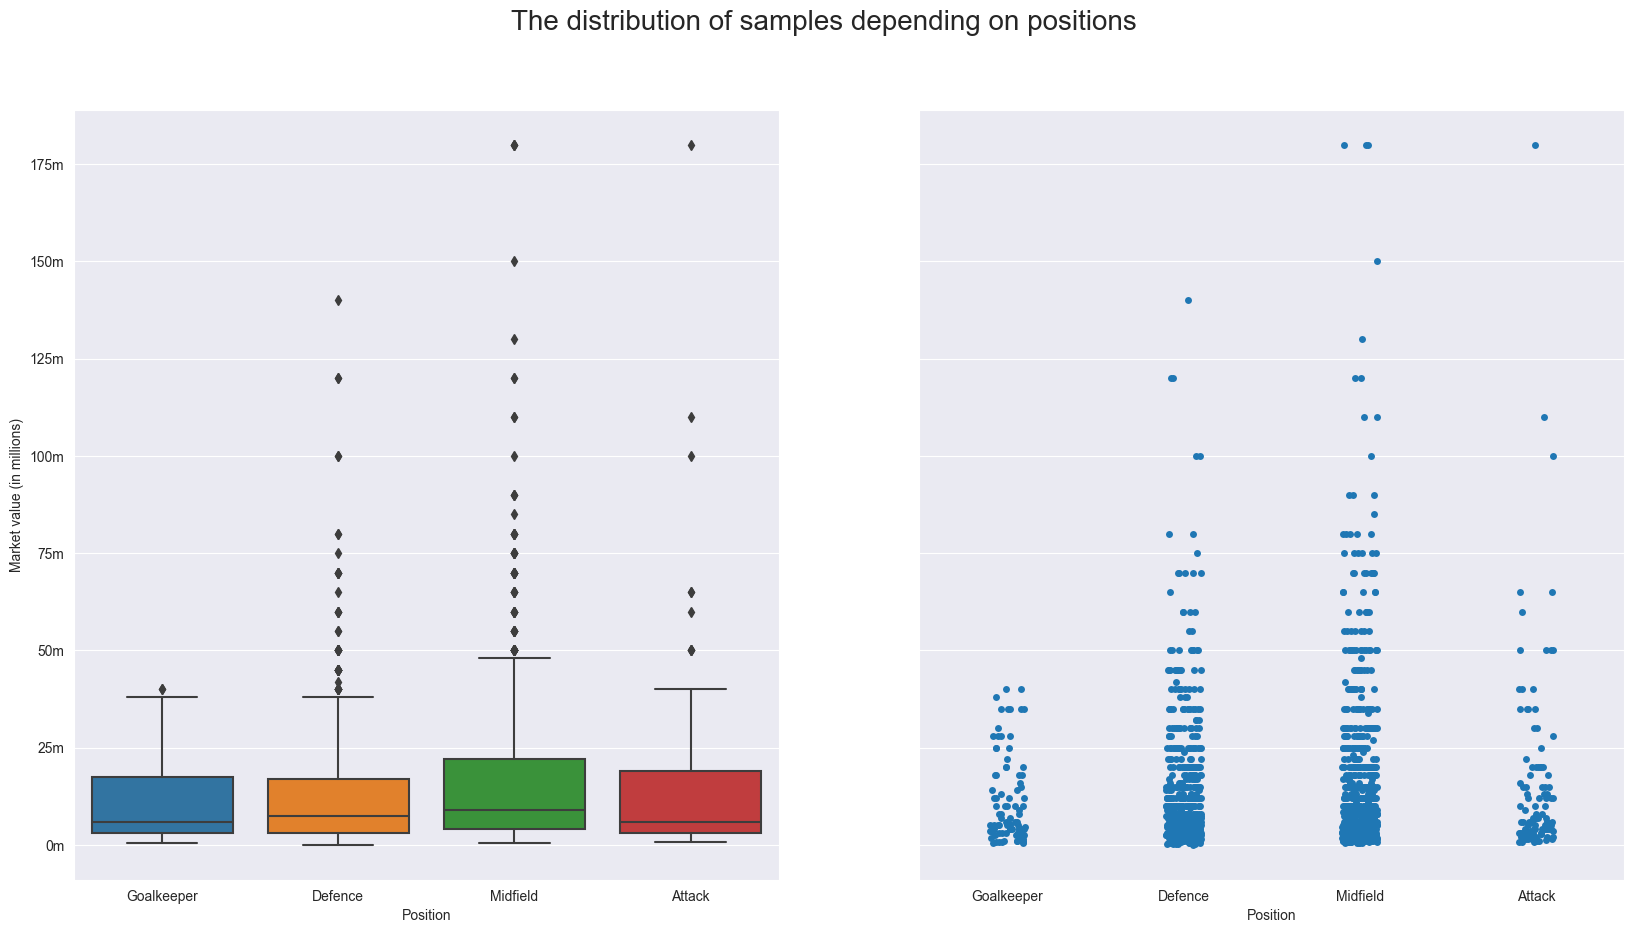

In [467]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

position_rank = ['Goalkeeper', 'Defence', 'Midfield', 'Attack']

sns.boxplot(all_data,
            x='Position',
            y='Value',
            order=position_rank,
            ax=ax[0])

sns.stripplot(all_data,
              x='Position',
              y='Value',
              order=position_rank,
              ax=ax[1])

fig.suptitle('The distribution of samples depending on positions', fontsize=20)
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_ylabel('')

plt.show()

In [468]:
display(descriptive_table(all_data, 'Position'))

,Sample size,Mean,St. deviation,Median,90% quantile
Position,,,,,
Attack,111,1.616396e+07,2.488179e+07,6000000.0,40000000.0
Defence,618,1.359684e+07,1.715473e+07,7500000.0,35000000.0
Goalkeeper,94,1.108936e+07,1.100055e+07,6000000.0,28000000.0
Midfield,723,1.771003e+07,2.305809e+07,9000000.0,45000000.0


In [469]:
# Significance test for some categorical variable
def significance_test(variable, transformation=False, test_type=None):
    groups = []

    for group in all_data[variable].unique():
        sample = all_data.query(variable + '== @group')['Value'].values
        
        if transformation == 'log': 
            sample = np.log(sample + 1)
        elif transformation == 'sqrt': 
            sample = np.sqrt(np.abs(sample))
            
        print(f'Shapiro-Wilk test: {shapiro(sample)}')
        groups.append(sample)

    print(f'Levene: {levene(*groups)}')
    
    if test_type == 'anova':
        print(f'ANOVA test: {f_oneway(*groups)}')
    elif test_type == 'kruskal':
        for g in groups:
            np.sort(g)
            
        print(f'Kruskal-Wallis test: {kruskal(*groups)}')

In [470]:
significance_test('Position')

Shapiro-Wilk test: ShapiroResult(statistic=0.6761902859086902, pvalue=6.197708076654985e-35)
Shapiro-Wilk test: ShapiroResult(statistic=0.820127441024127, pvalue=2.441868285597932e-09)
Shapiro-Wilk test: ShapiroResult(statistic=0.5910474408709383, pvalue=4.2454838122298744e-16)
Shapiro-Wilk test: ShapiroResult(statistic=0.6923282909868966, pvalue=4.8918881744521404e-32)
Levene: LeveneResult(statistic=5.071962668203488, pvalue=0.001695870592367609)


The samples aren`t distributed normally and their variances differ significantly, but we can use transformations

In [471]:
for tr in ['log', 'sqrt']:
    significance_test('Position', transformation=tr)
    print()
    print('=' * 25)
    print()

Shapiro-Wilk test: ShapiroResult(statistic=0.9911483603510157, pvalue=0.00025009395067626433)
Shapiro-Wilk test: ShapiroResult(statistic=0.9638427394140349, pvalue=0.010609204782735901)
Shapiro-Wilk test: ShapiroResult(statistic=0.9810127009464324, pvalue=0.11544302038132292)
Shapiro-Wilk test: ShapiroResult(statistic=0.9908761008326488, pvalue=0.0007225419010297908)
Levene: LeveneResult(statistic=0.23173730875181117, pvalue=0.8743134437741662)


Shapiro-Wilk test: ShapiroResult(statistic=0.8978465520242858, pvalue=1.5981228275437358e-21)
Shapiro-Wilk test: ShapiroResult(statistic=0.9240363383959092, pvalue=3.984101043060345e-05)
Shapiro-Wilk test: ShapiroResult(statistic=0.8419662299523764, pvalue=1.5549967643470708e-09)
Shapiro-Wilk test: ShapiroResult(statistic=0.9034120742644598, pvalue=2.527130728362949e-19)
Levene: LeveneResult(statistic=3.6987904334092474, pvalue=0.01140466767212007)




The samples` distribution is still abnormal, but their variances are homogenous, so we can try to use Kruskal-Wallis test (we cannot use ANOVA test)

In [472]:
print('Without transformation: ')
significance_test('Position', transformation=False, test_type='kruskal')

Without transformation: 
Shapiro-Wilk test: ShapiroResult(statistic=0.6761902859086902, pvalue=6.197708076654985e-35)
Shapiro-Wilk test: ShapiroResult(statistic=0.820127441024127, pvalue=2.441868285597932e-09)
Shapiro-Wilk test: ShapiroResult(statistic=0.5910474408709383, pvalue=4.2454838122298744e-16)
Shapiro-Wilk test: ShapiroResult(statistic=0.6923282909868966, pvalue=4.8918881744521404e-32)
Levene: LeveneResult(statistic=5.071962668203488, pvalue=0.001695870592367609)
Kruskal-Wallis test: KruskalResult(statistic=15.038079641393859, pvalue=0.0017843947425119037)


In [473]:
print('With log transformation: ')
significance_test('Position', transformation='log', test_type='kruskal')

With log transformation: 
Shapiro-Wilk test: ShapiroResult(statistic=0.9911483603510157, pvalue=0.00025009395067626433)
Shapiro-Wilk test: ShapiroResult(statistic=0.9638427394140349, pvalue=0.010609204782735901)
Shapiro-Wilk test: ShapiroResult(statistic=0.9810127009464324, pvalue=0.11544302038132292)
Shapiro-Wilk test: ShapiroResult(statistic=0.9908761008326488, pvalue=0.0007225419010297908)
Levene: LeveneResult(statistic=0.23173730875181117, pvalue=0.8743134437741662)
Kruskal-Wallis test: KruskalResult(statistic=15.038079641393859, pvalue=0.0017843947425119037)


Since Kruskal-Wallis test shows significant result, we can leave this variable

Let`s check 'Side_11' variable because it is footballer's main side (location where he usually plays)

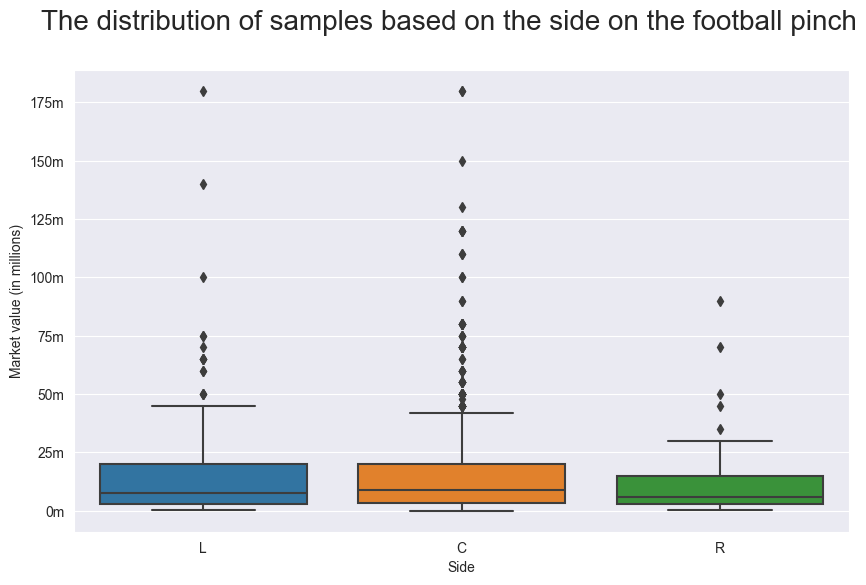

In [474]:
fig, ax = plt.subplots(figsize=(10, 6))

side_rank = ['L', 'C', 'R']

sns.boxplot(all_data,
            x='Side_11',
            y='Value',
            order=side_rank,
            ax=ax)

fig.suptitle('The distribution of samples based on the side on the football pinch', fontsize=20)
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')
ax.set_xlabel('Side')

plt.show()

In [475]:
descriptive_table(all_data, 'Side_11')

,Sample size,Mean,St. deviation,Median,90% quantile
Side_11,,,,,
C,881,1.690159e+07,2.164405e+07,9000000.0,42000000.0
L,237,1.511181e+07,2.128865e+07,7500000.0,35000000.0
R,115,1.097565e+07,1.338361e+07,6000000.0,25000000.0


In [476]:
all_data['Side_11'].fillna(all_data['Side_11'].mode().values[0], inplace=True)

In [477]:
all_data.rename(columns={'Side_11': 'Main side'}, inplace=True)

This variable is not so useful as the previous ones. There are too little data for Left and Right sides, and we can expect that 'Side_12', 'Side_13', etc. are even less informative, so in the future we can drop them, leaving only 'Main_side' (it is the same as 'Side_11') variable.

Now we will work with 'Position_1_Sides' and 'Position_2_Sides' and create some interesting (at least we hope) plots

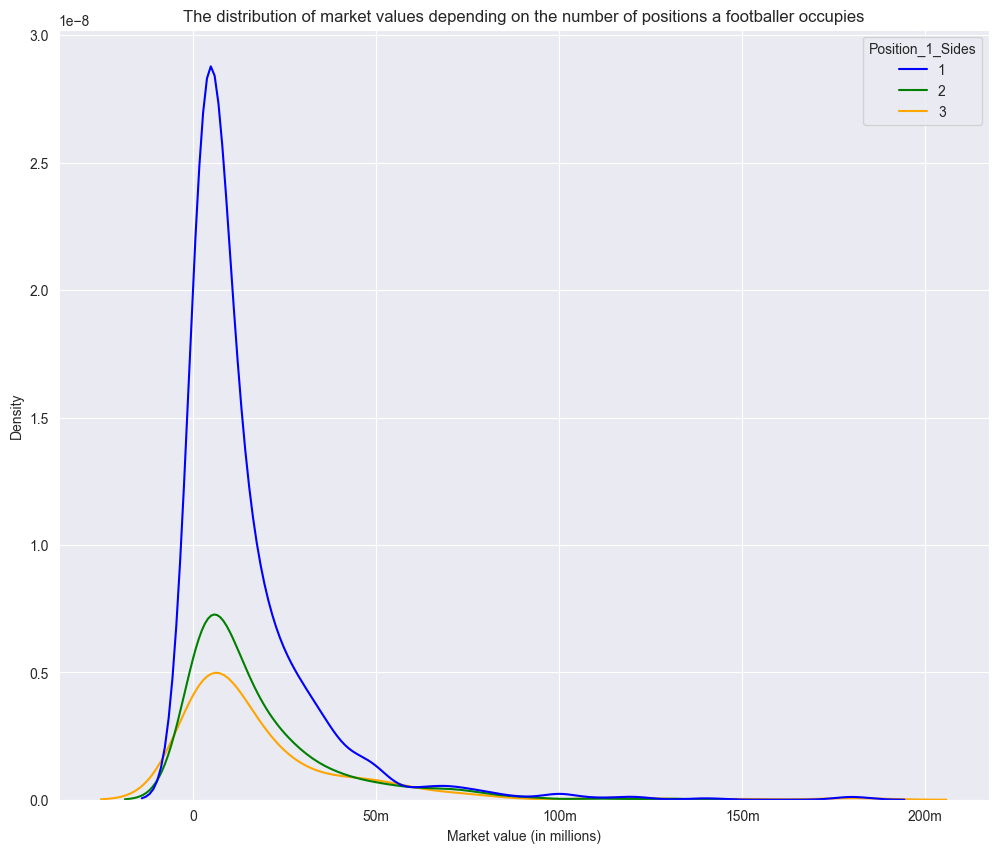

In [478]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='Position_1_Sides',
            palette=['blue', 'green', 'orange'])

ax.set_title('The distribution of market values depending on the number of positions a footballer occupies')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

Now let`s work with numerical variables  

In [479]:
all_data.describe()

,Age,Mins,Goals,Assists,Yel,Red,SpG,PS,AerialsWon,MotM,...,UnsTch,AvgP,Crosses,LongB,ThrB,Overall_Apps,Start_Apps,Value,Position_1_Sides,Position_2_Sides
count,1546.000000,1546.000000,1546.000000,1546.000000,1546.00000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,...,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1546.000000,1.546000e+03,1546.000000,1546.000000
mean,26.873868,1918.762613,2.850582,2.004528,3.93467,0.174644,0.894825,80.035511,0.962678,1.038163,...,0.991074,31.006468,0.301035,1.638616,0.040621,17.393920,7.135834,1.555226e+07,1.563389,1.077620
std,4.115202,706.446517,3.931821,2.298863,2.68333,0.415591,0.692623,7.927905,0.852841,1.464300,...,0.654077,16.395636,0.413790,1.662868,0.070546,9.582248,5.527306,2.054976e+07,0.770948,0.328462
min,16.000000,195.000000,0.000000,0.000000,0.00000,0.000000,0.000000,44.900000,0.000000,0.000000,...,0.000000,3.600000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000e+04,1.000000,1.000000
25%,24.000000,1376.250000,0.000000,0.000000,2.00000,0.000000,0.400000,75.700000,0.400000,0.000000,...,0.500000,18.525000,0.000000,0.500000,0.000000,10.000000,3.000000,3.000000e+06,1.000000,1.000000
50%,27.000000,1913.000000,1.000000,1.000000,4.00000,0.000000,0.700000,81.100000,0.700000,1.000000,...,0.900000,28.800000,0.100000,1.100000,0.000000,18.000000,5.000000,8.000000e+06,1.000000,1.000000
75%,30.000000,2485.000000,4.000000,3.000000,5.00000,0.000000,1.275000,85.600000,1.300000,2.000000,...,1.400000,40.700000,0.400000,2.200000,0.100000,25.000000,11.000000,2.000000e+07,2.000000,1.000000
max,40.000000,3420.000000,36.000000,14.000000,17.00000,3.000000,4.600000,95.400000,6.800000,10.000000,...,3.700000,106.900000,2.900000,15.400000,0.600000,37.000000,28.000000,1.800000e+08,3.000000,3.000000


In [480]:
df_train, df_test = divide_df(all_data)

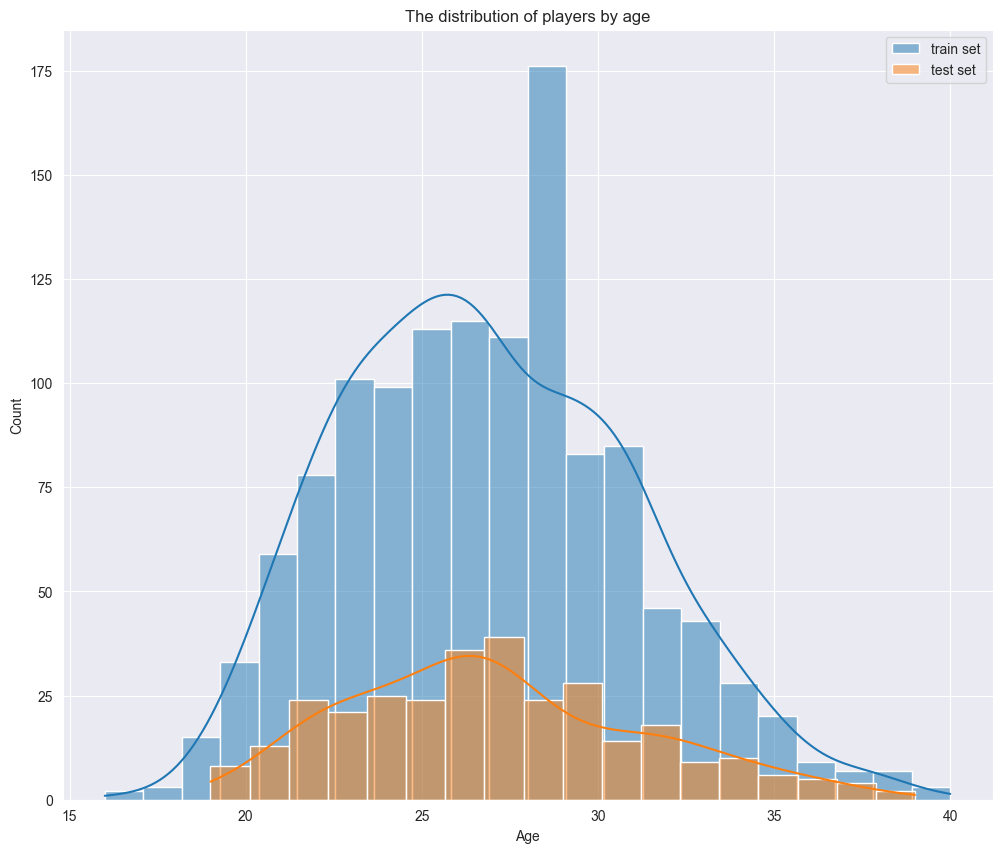

In [481]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.histplot(df_train,
            x='Age',
            kde=True,
            ax=ax,
            label='train set')

sns.histplot(df_test,
            x='Age',
            kde=True,
            bins=18,
            ax=ax,
            label='test set')

ax.set_title('The distribution of players by age')
ax.set_xlabel('Age')
ax.legend()

plt.show()

In [482]:
all_data['Age'] = pd.cut(all_data['Age'], bins=4)

In [483]:
df_train, df_test = divide_df(all_data)

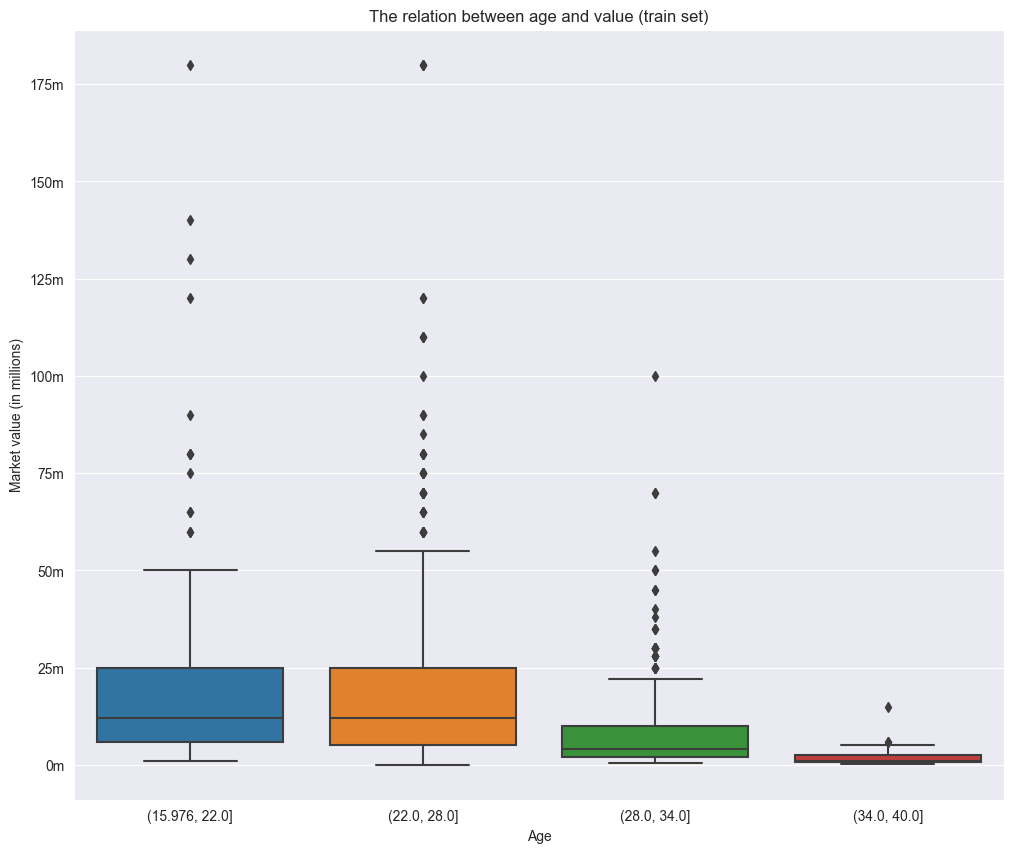

In [484]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.boxplot(df_train,
            x='Age',
            y='Value',
            ax=ax)

ax.set_title('The relation between age and value (train set)')
ax.set_xlabel('Age')
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')

plt.show()

In [485]:
descriptive_table(df_train, 'Age')

,Sample size,Mean,St. deviation,Median,90% quantile
Age,,,,,
"(15.976, 22.0]",190,2.094263e+07,2.500233e+07,12000000.0,45000000.0
"(22.0, 28.0]",619,1.944758e+07,2.307022e+07,12000000.0,45000000.0
"(28.0, 34.0]",381,8.548950e+06,1.121825e+07,4000000.0,22000000.0
"(34.0, 40.0]",46,2.033696e+06,2.518290e+06,1000000.0,5000000.0


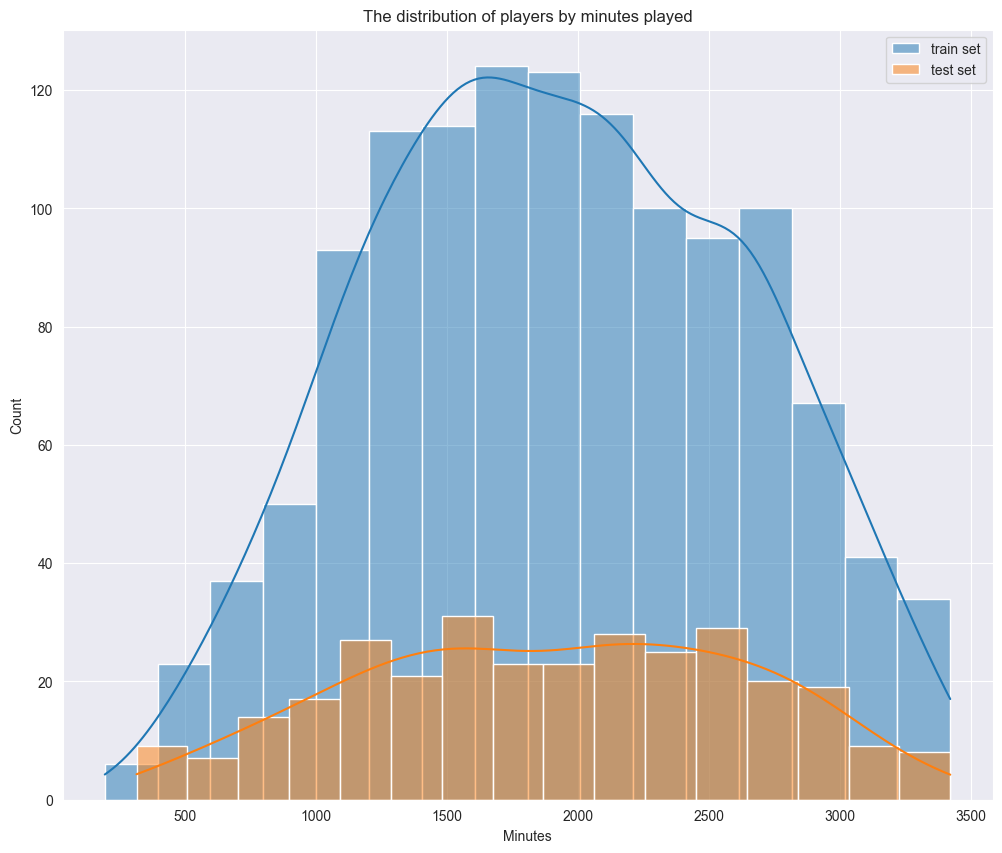

In [486]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.histplot(df_train,
            x='Mins',
            kde=True,
            ax=ax,
            label='train set')

sns.histplot(df_test,
            x='Mins',
            kde=True,
            bins=16,
            ax=ax,
            label='test set')

ax.set_title('The distribution of players by minutes played')
ax.set_xlabel('Minutes')
ax.legend()

plt.show()

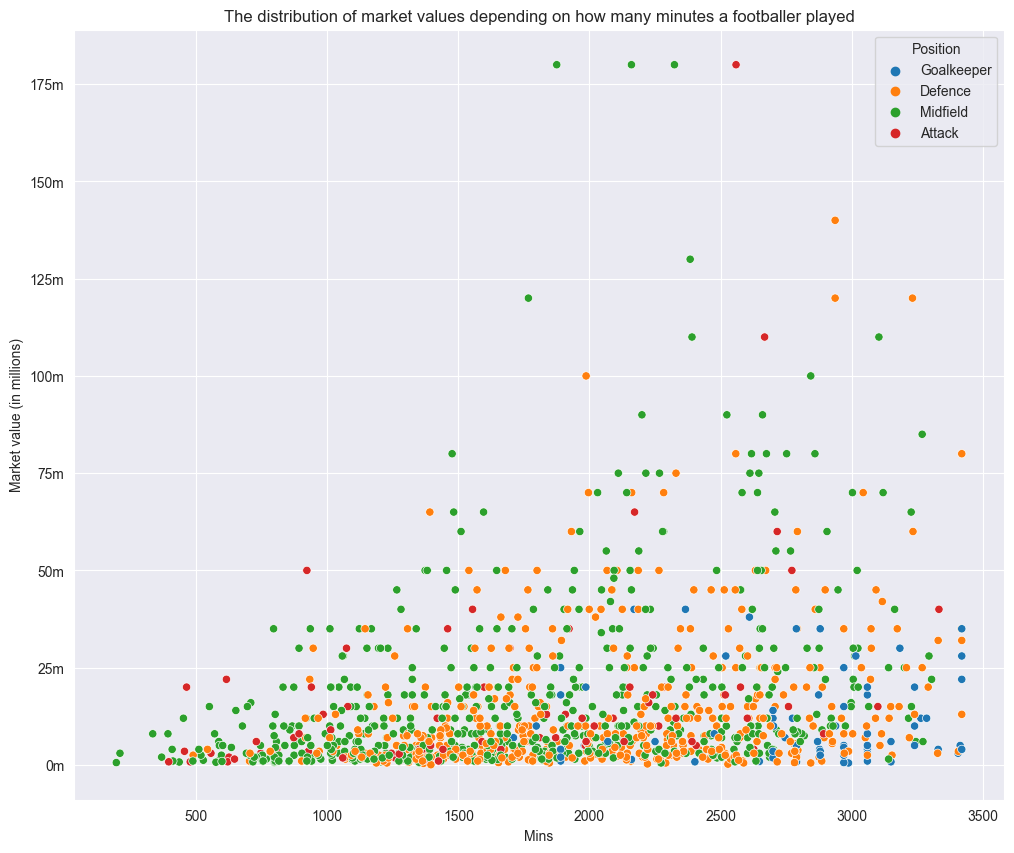

In [487]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.scatterplot(df_train,
            x='Mins',
            y='Value',
            hue='Position',
            hue_order=position_rank,
            ax=ax)

ax.set_title('The distribution of market values depending on how many minutes a footballer played')
ax.set_xlabel('Mins')
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')

plt.show()

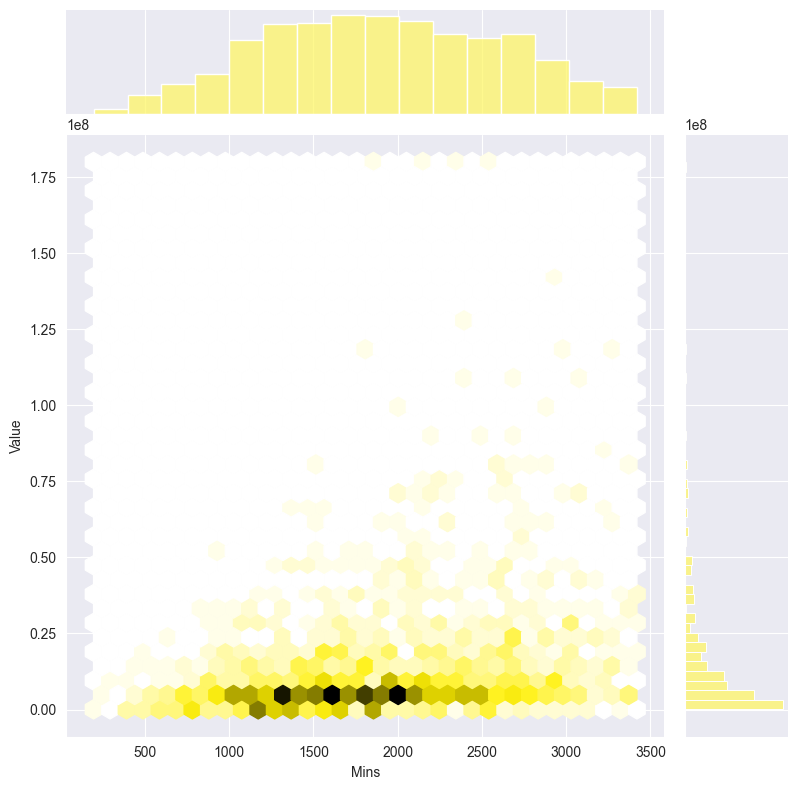

In [488]:
sns.jointplot(df_train,
              x='Mins',
              y='Value',
              kind="hex", 
              height=8,
              color="#FFF668")

plt.show()

In [489]:
#all_data['Minutes for MotM'] = all_data['Mins'] / all_data['MotM']
#all_data['Minutes for Goal'] = all_data['Mins'] / all_data['Goals']
#all_data['Minutes for Assist'] = all_data['Mins'] / all_data['Assists']
#all_data['Minutes for KeyP'] = all_data['Mins'] / all_data['KeyP']

In [490]:
all_data['Mins'] = pd.qcut(all_data['Mins'], q=4)
df_train, df_test = divide_df(all_data)

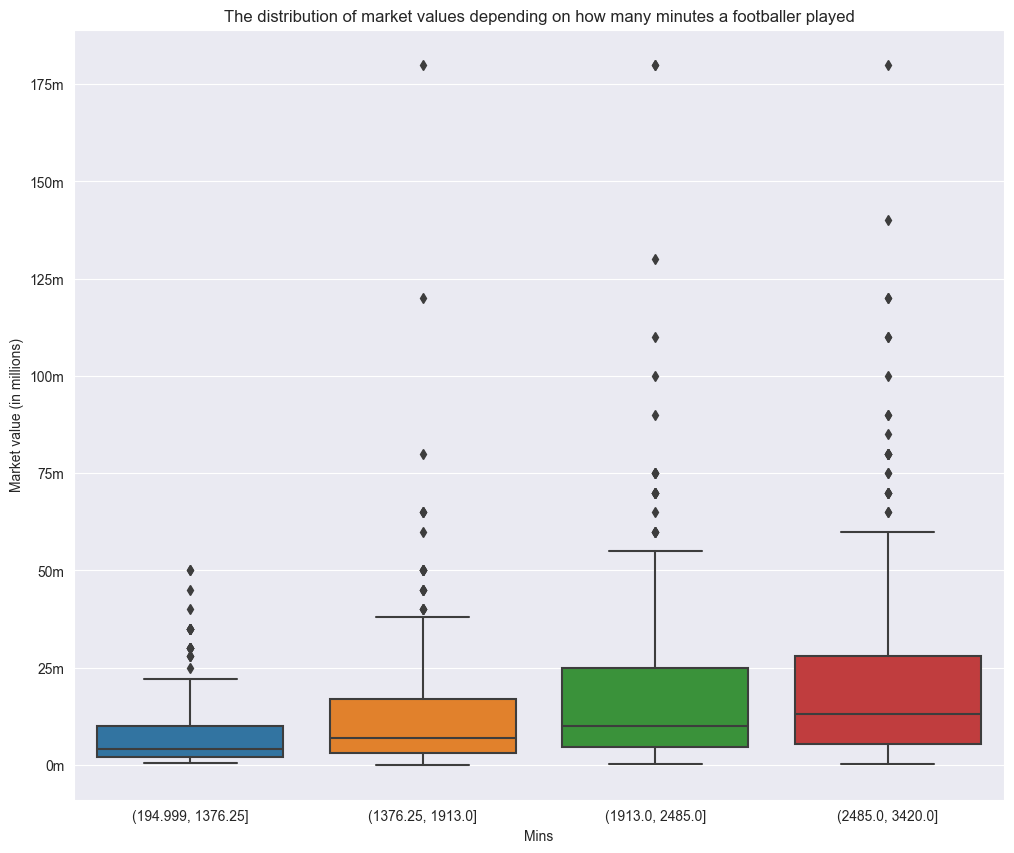

In [491]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.boxplot(df_train,
            x='Mins',
            y='Value',
            ax=ax)

ax.set_title('The distribution of market values depending on how many minutes a footballer played')
ax.set_xlabel('Mins')
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')

plt.show()

In [492]:
descriptive_table(df_train, 'Mins')

,Sample size,Mean,St. deviation,Median,90% quantile
Mins,,,,,
"(194.999, 1376.25]",305,8.201148e+06,9.354858e+06,4000000.0,20000000.0
"(1376.25, 1913.0]",318,1.307123e+07,1.735561e+07,7000000.0,30000000.0
"(1913.0, 2485.0]",307,1.910993e+07,2.420692e+07,10000000.0,48800000.0
"(2485.0, 3420.0]",306,2.236307e+07,2.556026e+07,13000000.0,52500000.0


In [493]:
all_data['Goals'] = pd.cut(all_data['Goals'], bins=4)
all_data['Assists'] = pd.cut(all_data['Assists'], bins=4)

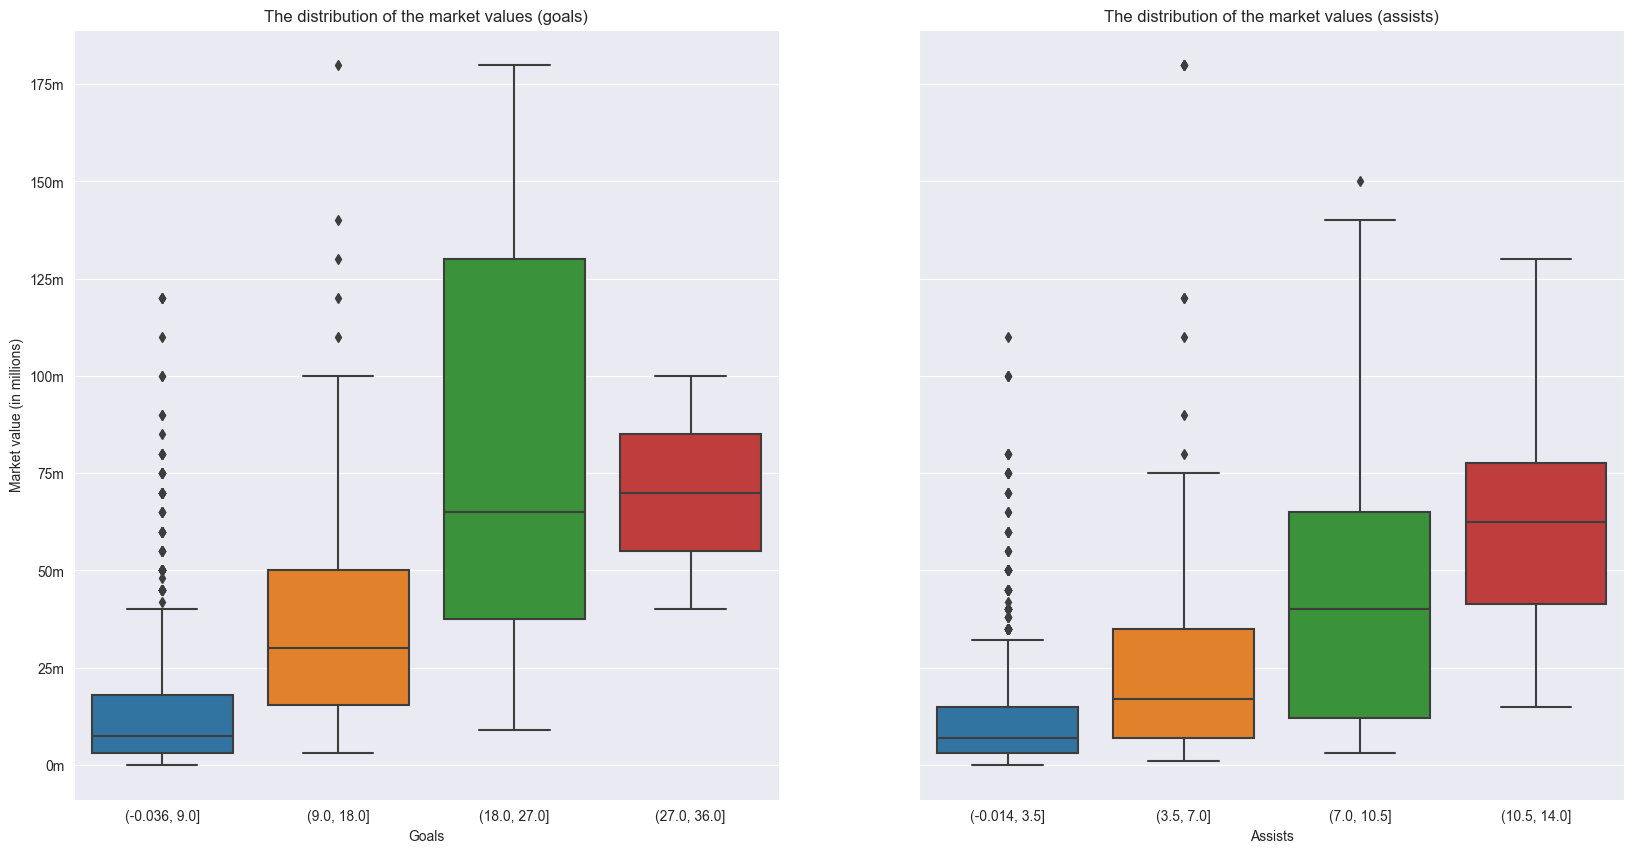

In [494]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

sns.boxplot(all_data,
            x='Goals',
            y='Value',
            ax=ax[0])

sns.boxplot(all_data,
            x='Assists',
            y='Value',
            ax=ax[1])

ax[0].set_title('The distribution of the market values (goals)')
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_title('The distribution of the market values (assists)')
ax[1].set_ylabel('')

plt.show()

In [495]:
for item in ['Goals', 'Assists']:
    print(f'Variable: {item}')
    display(descriptive_table(all_data, item))

Variable: Goals


,Sample size,Mean,St. deviation,Median,90% quantile
Goals,,,,,
"(-0.036, 9.0]",1446,1.345768e+07,1.625314e+07,7500000.0,35000000.0
"(9.0, 18.0]",83,3.843373e+07,3.325188e+07,30000000.0,70000000.0
"(18.0, 27.0]",15,8.360000e+07,6.156970e+07,65000000.0,180000000.0
"(27.0, 36.0]",2,7.000000e+07,4.242641e+07,70000000.0,94000000.0


Variable: Assists


,Sample size,Mean,St. deviation,Median,90% quantile
Assists,,,,,
"(-0.014, 3.5]",1260,1.205135e+07,1.427802e+07,7000000.0,30000000.0
"(3.5, 7.0]",223,2.626502e+07,3.036211e+07,17000000.0,55000000.0
"(7.0, 10.5]",53,4.484906e+07,3.765961e+07,40000000.0,98000000.0
"(10.5, 14.0]",10,6.250000e+07,3.129164e+07,62500000.0,85000000.0


Let`s drop redundant features or the features with missing values

In [496]:
all_data.drop(['Side_12', 'Side_13', 'Side_21', 'Side_22', 'League', 'Team',
               'Side_23', 'Position_1', 'Position_2', 'Position_2_Sides'], axis=1, inplace=True)

all_data, all_names = all_data.drop('Name', axis=1), all_data['Name']

train_names, test_names = divide_df(all_names) 

In [497]:
all_data.sample(10)

,Age,Mins,Goals,Assists,Yel,Red,SpG,PS,AerialsWon,MotM,...,LongB,ThrB,Overall_Apps,Start_Apps,Main side,Value,Position_1_Sides,Team_rank,From EPL,Position
488,"(28.0, 34.0]","(1913.0, 2485.0]","(-0.036, 9.0]","(-0.014, 3.5]",5,0,0.6,83.1,3.5,1,...,3.7,0.0,2,2,C,10000000,1,C-tier,False,Defence
177,"(28.0, 34.0]","(2485.0, 3420.0]","(-0.036, 9.0]","(3.5, 7.0]",7,0,1.0,84.6,0.8,4,...,2.2,0.1,29,3,L,25000000,2,A-tier,False,Defence
674,"(22.0, 28.0]","(194.999, 1376.25]","(-0.036, 9.0]","(-0.014, 3.5]",1,0,0.9,77.1,0.7,0,...,0.3,0.0,2,21,C,3000000,1,C-tier,False,Attack
217,"(15.976, 22.0]","(2485.0, 3420.0]","(9.0, 18.0]","(7.0, 10.5]",4,0,3.1,83.0,0.7,6,...,0.8,0.0,3,3,L,140000000,1,A-tier,True,Defence
1342,"(22.0, 28.0]","(1376.25, 1913.0]","(-0.036, 9.0]","(-0.014, 3.5]",5,0,0.6,86.2,1.0,0,...,1.5,0.0,17,15,C,28000000,3,A-tier,True,Defence
993,"(22.0, 28.0]","(1376.25, 1913.0]","(-0.036, 9.0]","(-0.014, 3.5]",5,0,0.4,91.8,1.2,0,...,2.5,0.0,16,4,C,14000000,1,B-tier,False,Defence
1200,"(28.0, 34.0]","(194.999, 1376.25]","(-0.036, 9.0]","(-0.014, 3.5]",3,1,0.7,77.8,0.5,0,...,0.3,0.0,7,21,L,2000000,2,C-tier,False,Midfield
1056,"(28.0, 34.0]","(1376.25, 1913.0]","(-0.036, 9.0]","(-0.014, 3.5]",0,0,0.0,86.3,0.4,0,...,4.6,0.0,2,2,C,2000000,1,B-tier,False,Goalkeeper
465,"(15.976, 22.0]","(194.999, 1376.25]","(-0.036, 9.0]","(-0.014, 3.5]",2,0,0.4,83.2,0.5,0,...,0.3,0.0,11,15,R,15000000,1,B-tier,False,Defence
13,"(22.0, 28.0]","(1376.25, 1913.0]","(-0.036, 9.0]","(-0.014, 3.5]",5,0,1.0,86.5,0.8,1,...,0.6,0.1,17,12,C,9000000,2,B-tier,False,Midfield


In [498]:
def pairplot_creator(table, index_start=0, index_end=40):
    new_table = table.iloc[:, index_start:index_end]
    new_table['Value'] = table['Value']
    
    sns.pairplot(new_table, height=2)
    plt.show()

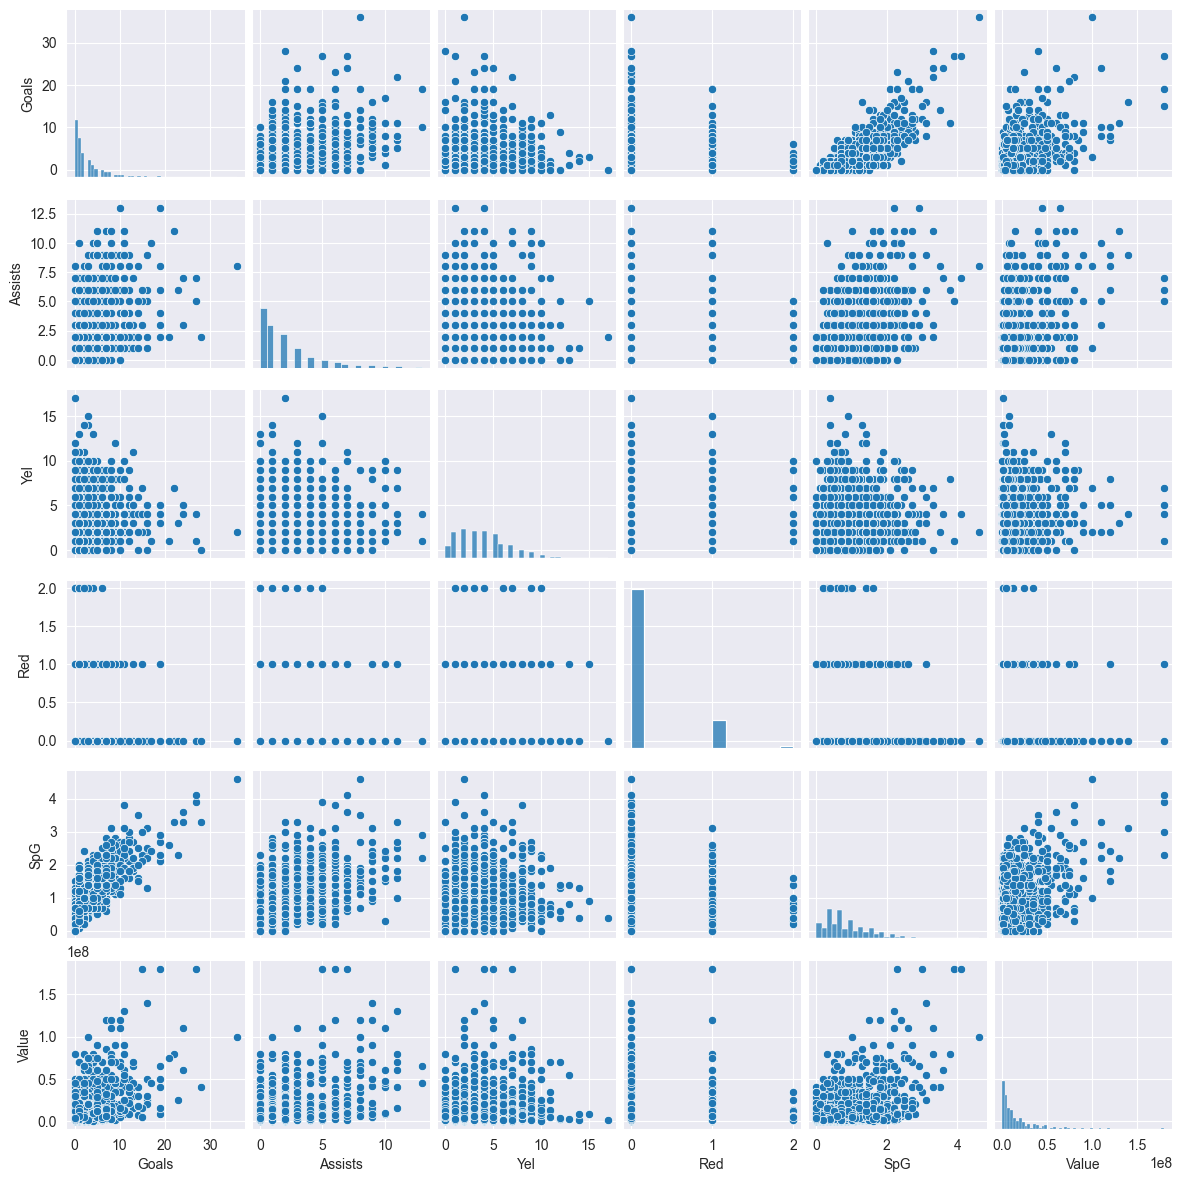

In [499]:
pairplot_creator(df_train, index_start=4, index_end=9)

In [500]:
# Insert 'Value' variable at the end of the dataset
value_column = all_data.pop('Value')
all_data['Value'] = value_column

In [501]:
df_train, df_test = divide_df(all_data)

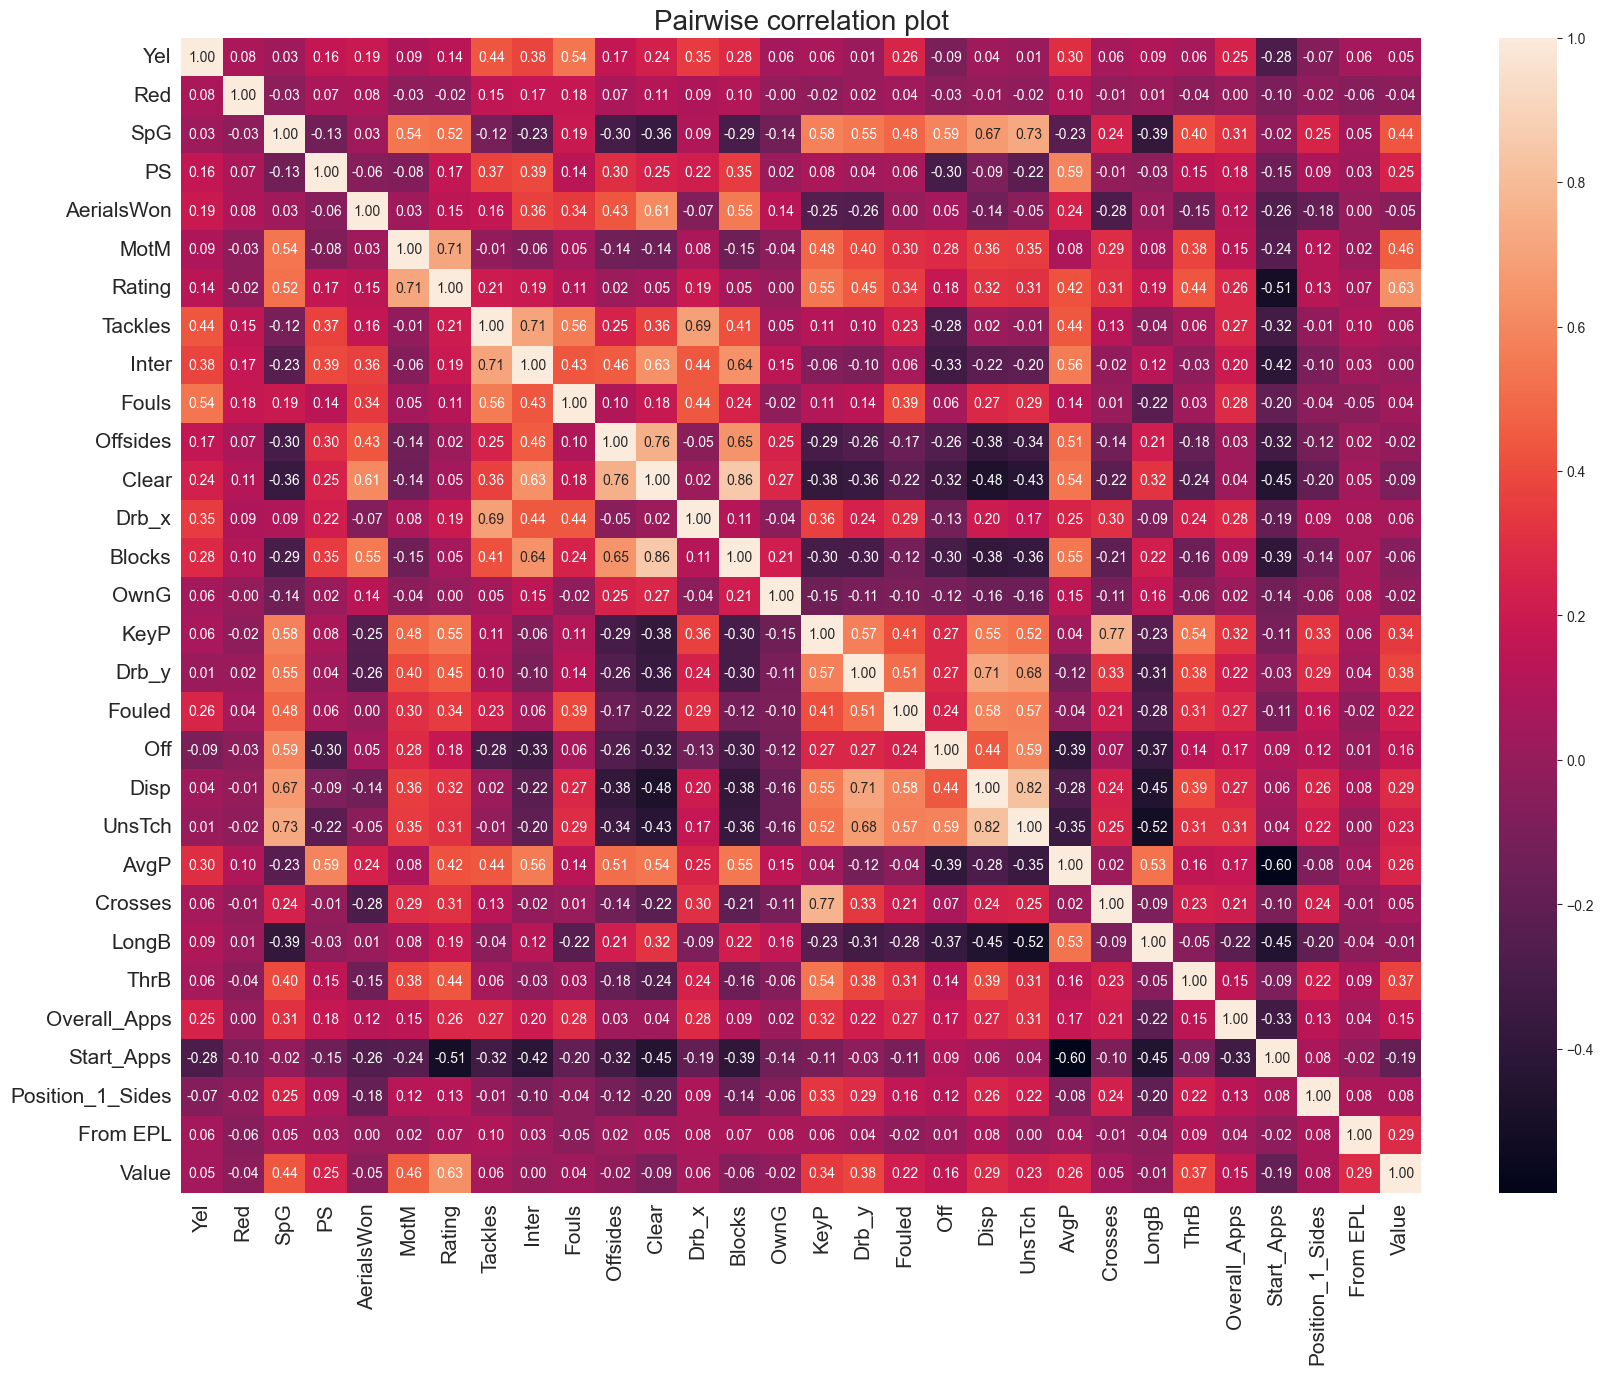

In [502]:
corr_table = df_train.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(20, 15))

sns.heatmap(corr_table,
            annot=True,
            fmt='.2f',
            ax=ax)

ax.set_title('Pairwise correlation plot', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

Let`s check the variance of some variables and use filter methods of feature selection

In [503]:
low_variance_correlation = []

for item in all_data.columns:
    if (all_data[item].dtype == 'int64' or all_data[item].dtype == 'float') and not item.startswith('Minutes'):
        print(f'Variable: {item}')
        variance = all_data[item].values.var()
        correlation = np.corrcoef(all_data[item].values, all_data['Value'].values)[0][1]
        print(f'Its variance: {variance}')
        print(f'Its correlation with the target variable: {correlation}')
        print('=' * 25)
        
        if variance < 0.2 and correlation < 0.1:
            low_variance_correlation.append(item)

Variable: Yel
Its variance: 7.195602640206583
Its correlation with the target variable: 0.07362754938609456
Variable: Red
Its variance: 0.1726041748601323
Its correlation with the target variable: -0.022873579730049463
Variable: SpG
Its variance: 0.4794169488008114
Its correlation with the target variable: 0.43160653793016174
Variable: PS
Its variance: 62.81102228092695
Its correlation with the target variable: 0.23684407418724257
Variable: AerialsWon
Its variance: 0.726867085112187
Its correlation with the target variable: -0.04096198717153944
Variable: MotM
Its variance: 2.142786793611691
Its correlation with the target variable: 0.44773174839481883
Variable: Rating
Its variance: 0.07274254772571709
Its correlation with the target variable: 0.61532942805496
Variable: Tackles
Its variance: 0.44861280791392555
Its correlation with the target variable: 0.05808291315242872
Variable: Inter
Its variance: 0.1888183502390679
Its correlation with the target variable: 0.002694347276444585
Vari

In [504]:
all_data.drop(low_variance_correlation, axis=1, inplace=True)

In [505]:
all_data.sample(5)

,Age,Mins,Goals,Assists,Yel,SpG,PS,AerialsWon,MotM,Rating,...,LongB,ThrB,Overall_Apps,Start_Apps,Main side,Position_1_Sides,Team_rank,From EPL,Position,Value
395,"(15.976, 22.0]","(1376.25, 1913.0]","(-0.036, 9.0]","(-0.014, 3.5]",4,0.6,82.4,0.3,1,6.43,...,1.3,0.1,21,11,C,1,C-tier,False,Midfield,5000000
1307,"(22.0, 28.0]","(194.999, 1376.25]","(-0.036, 9.0]","(-0.014, 3.5]",1,1.0,85.3,0.2,0,6.36,...,0.3,0.0,4,14,C,2,B-tier,False,Midfield,3500000
1468,"(15.976, 22.0]","(1376.25, 1913.0]","(-0.036, 9.0]","(-0.014, 3.5]",4,0.5,71.4,0.5,0,6.37,...,0.4,0.0,20,11,R,1,C-tier,False,Midfield,6000000
393,"(22.0, 28.0]","(1376.25, 1913.0]","(-0.036, 9.0]","(-0.014, 3.5]",5,1.1,75.9,1.7,0,6.48,...,0.8,0.0,18,5,C,1,B-tier,False,Midfield,7000000
117,"(28.0, 34.0]","(2485.0, 3420.0]","(-0.036, 9.0]","(-0.014, 3.5]",9,0.9,71.1,4.5,2,6.90,...,2.6,0.0,3,3,C,3,C-tier,False,Defence,5500000


In [506]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               1546 non-null   category
 1   Mins              1546 non-null   category
 2   Goals             1546 non-null   category
 3   Assists           1546 non-null   category
 4   Yel               1546 non-null   int64   
 5   SpG               1546 non-null   float64 
 6   PS                1546 non-null   float64 
 7   AerialsWon        1546 non-null   float64 
 8   MotM              1546 non-null   int64   
 9   Rating            1546 non-null   float64 
 10  Tackles           1546 non-null   float64 
 11  Clear             1546 non-null   float64 
 12  KeyP              1546 non-null   float64 
 13  Drb_y             1546 non-null   float64 
 14  Fouled            1546 non-null   float64 
 15  Off               1546 non-null   float64 
 16  Disp              1546 n

In [507]:
all_data.columns

Index(['Age', 'Mins', 'Goals', 'Assists', 'Yel', 'SpG', 'PS', 'AerialsWon',
       'MotM', 'Rating', 'Tackles', 'Clear', 'KeyP', 'Drb_y', 'Fouled', 'Off',
       'Disp', 'UnsTch', 'AvgP', 'LongB', 'ThrB', 'Overall_Apps', 'Start_Apps',
       'Main side', 'Position_1_Sides', 'Team_rank', 'From EPL', 'Position',
       'Value'],
      dtype='object')

In [508]:
all_data.sample(5)

,Age,Mins,Goals,Assists,Yel,SpG,PS,AerialsWon,MotM,Rating,...,LongB,ThrB,Overall_Apps,Start_Apps,Main side,Position_1_Sides,Team_rank,From EPL,Position,Value
910,"(15.976, 22.0]","(1376.25, 1913.0]","(-0.036, 9.0]","(-0.014, 3.5]",5,1.1,71.4,0.5,1,6.82,...,0.4,0.1,19,9,C,1,C-tier,False,Midfield,20000000
1440,"(22.0, 28.0]","(1913.0, 2485.0]","(-0.036, 9.0]","(-0.014, 3.5]",3,1.1,79.8,1.2,2,6.55,...,1.1,0.0,24,10,C,2,C-tier,False,Midfield,5000000
261,"(22.0, 28.0]","(1376.25, 1913.0]","(-0.036, 9.0]","(-0.014, 3.5]",2,0.5,79.8,0.5,0,6.52,...,1.8,0.1,1,1,L,1,C-tier,False,Defence,7000000
1517,"(22.0, 28.0]","(2485.0, 3420.0]","(-0.036, 9.0]","(-0.014, 3.5]",2,0.0,69.2,0.5,3,6.71,...,8.3,0.0,3,3,C,1,C-tier,False,Goalkeeper,8000000
105,"(22.0, 28.0]","(194.999, 1376.25]","(-0.036, 9.0]","(3.5, 7.0]",5,2.4,82.5,0.4,3,6.76,...,0.4,0.0,17,4,L,1,C-tier,False,Midfield,6000000


**Feature transformation**

In [509]:
label_encoding = ['Age', 'Mins', 'Goals', 'Assists', 'Main side', 'Team_rank', 'Position']
one_hot_encoding = ['Main side', 'Position']

In [510]:
label_enc = LabelEncoder()

for label in label_encoding:
    all_data[label] = label_enc.fit_transform(all_data[label])

In [511]:
all_data = pd.get_dummies(all_data, columns=one_hot_encoding, drop_first=True)

**3. LEARNING A MODEL**

This section will be divided into 3 parts. In the first part we will create the DecisionTree model to see how it makes decisions on the data and how well it performs. In the next part we will examine all the basic machine learning models in order to choose the best one. In the final part we will choose one of the algorithms and learn it via GridSearch with a larger hyperparameters grid 

In [512]:
df_train, df_test = divide_df(all_data)

X_train, y_train = df_train.drop('Value', axis=1), df_train['Value']
X_test, y_test = df_test.drop('Value', axis=1), df_test['Value']

*1. Decision Tree*

In this part we will create a basic decision tree and then visualize it. This model is good at representativeness and interpretability so we must know how to deal with it

In [583]:
basic_decision_tree = DecisionTreeRegressor()

In [584]:
basic_decision_tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [576]:
#fig, ax = plt.subplots(figsize=(25, 20))

#plot_tree(basic_decision_tree, feature_names=X_train.columns, filled=True)
#plt.show()

In [585]:
root_mean_squared_error(basic_decision_tree.predict(X_train), y_train)

0.0

In [586]:
root_mean_squared_log_error(basic_decision_tree.predict(X_train), y_train)

0.0

In [587]:
answers = pd.DataFrame([test_names.values, y_test.values, pd.Series(basic_decision_tree.predict(X_test))]).T
answers.rename(columns={0: 'Name', 1: 'Test value', 2: 'Predicted value'}, inplace=True)

In [588]:
root_mean_squared_error(basic_decision_tree.predict(X_test), y_test)

14717899.460049625

In [589]:
root_mean_squared_log_error(basic_decision_tree.predict(X_test), y_test)

0.8681868565911721

In [590]:
display(answers.sample(50))

,Name,Test value,Predicted value
9,Igor Zubeldia,22000000,8000000.0
113,Rodrigo Riquelme,25000000,35000000.0
150,Anthony Lopes,4000000,10000000.0
123,David Raum,20000000,12000000.0
135,Matús Bero,3500000,1200000.0
105,Morgan Sanson,8000000,7000000.0
148,Matteo Cancellieri,4800000,9000000.0
248,Taiwo Awoniyi,28000000,18000000.0
288,Domagoj Bradaric,5000000,2500000.0
102,Ander Barrenetxea,20000000,18000000.0
